# Frequency Analysis

<br>

#### Information in Frequency Measurements Folder

Frequency meter Mutatio timesynch problem:

Since 2016-04-21:
No synchronisation with time server.

Time Jump
double data in files
corrections in korr-vorn 
korr-hinten still ca 40 days wrong timestamp

New start
since 2017-02 timesync-problem solved

<br>

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pytz
from datetime import datetime

import os

<br>

### Reading in Data

First we'll create a list containing the filenames which contain the frequency data

In [2]:
filenames = os.listdir('data/frequency') 

print(f'Total of {len(filenames)} files')
print(f'First 5: {filenames[:5]}')

Total of 259 files
First 5: ['2016068.TXT', '2016069.TXT', '2016070.TXT', '2016071.TXT', '2016072.TXT']


<br>

Next we'll read in a single file

We define the filepath, separator and columns, then drop the two unnecessary columns

In [72]:
pd.read_csv('data/frequency/2016068.TXT').head()

,1457395248.161 50.06573 61 11
0,1457395249.160\t 50.07156\t69\t11
1,1457395250.158\t 50.08883\t56\t11
2,1457395251.156\t 50.09247\t60\t11
3,1457395252.155\t 50.06212\t66\t11
4,1457395253.154\t 50.03595\t61\t11


In [18]:
%%time

def read_in(filename):
    columns= ['UTC_timestamp', 'frequency_Hz', 'drop1', 'drop2']
    filepath = f'data/frequency/{filename}'

    df_freq = (pd
               .read_csv(filepath, 
                           sep='\t', 
                           header=None, 
                           names=columns)
               .drop(columns=['drop1', 'drop2'])
              )
    
    return df_freq

df_freq = read_in(filenames[0])

Wall time: 94.8 ms


In [19]:
print(f'Dataframe Shape: {df_freq.shape}\n')
df_freq.head()

Dataframe Shape: (83319, 2)



,UTC_timestamp,frequency_Hz
0,1.457395e+09,50.06573
1,1.457395e+09,50.07156
2,1.457395e+09,50.08883
3,1.457395e+09,50.09247
4,1.457395e+09,50.06212


<br>

### Cleaning the Data

The first step in this initial clean of the data is to convert the timestamp to the correct format

In [14]:
%%time

df_freq['UTC_timestamp'] = df_freq.UTC_timestamp.apply(lambda ts: pd.to_datetime(datetime.utcfromtimestamp(ts)))
df_freq['UTC_timestamp'] = pd.to_datetime(df_freq['UTC_timestamp'])

Wall time: 5.71 s


In [15]:
df_freq.head()

,UTC_timestamp,frequency_Hz
0,2016-03-08 00:00:48.161,50.06573
1,2016-03-08 00:00:49.160,50.07156
2,2016-03-08 00:00:50.158,50.08883
3,2016-03-08 00:00:51.156,50.09247
4,2016-03-08 00:00:52.155,50.06212


In [7]:
df_freq.head()

,UTC_timestamp,frequency_Hz
0,2016-03-08 00:00:48,50.06573
1,2016-03-08 00:00:49,50.07156
2,2016-03-08 00:00:50,50.08883
3,2016-03-08 00:00:51,50.09247
4,2016-03-08 00:00:52,50.06212


<br>

Finally we'll convert the datetimes into the correct timezone

As we can see below there is no timezone information contained within the datetime metadata

In [8]:
df_freq.UTC_timestamp[0].isoformat()

'2016-03-08T00:00:48'

In [9]:
print(df_freq.UTC_timestamp[0].tzinfo)

None


<br>

We now define the timezone the measurements were recorded in and the timezone we wish to convert them into

In [17]:
measurement_tz = pytz.timezone('UTC')
island_tz = pytz.timezone('Atlantic/Canary')

island_tz

<DstTzInfo 'Atlantic/Canary' LMT-1 day, 22:58:00 STD>

In [11]:
%%time

df_freq['UTC_timestamp'] = df_freq['UTC_timestamp'].apply(lambda datetime: measurement_tz.localize(datetime))
df_freq['UTC_timestamp'] = df_freq['UTC_timestamp'].apply(lambda datetime: datetime.astimezone(island_tz))

Wall time: 2.82 s


In [12]:
df_freq.head()

,UTC_timestamp,frequency_Hz
0,2016-03-08 00:00:48+00:00,50.06573
1,2016-03-08 00:00:49+00:00,50.07156
2,2016-03-08 00:00:50+00:00,50.08883
3,2016-03-08 00:00:51+00:00,50.09247
4,2016-03-08 00:00:52+00:00,50.06212


<br>

### Combining Read In & Formatting

In [22]:
%%time

def read_n_format_file(filename):
    ## Reading in Data
    df_freq = read_in(filename)

    ## Converting UNIX Timestamp to UTC
    df_freq['UTC_timestamp'] = df_freq.UTC_timestamp.apply(lambda ts: pd.to_datetime(datetime.utcfromtimestamp(ts)))
    df_freq['UTC_timestamp'] = pd.to_datetime(df_freq['UTC_timestamp'])

    ## Assigning & Converting Timezones
    measurement_tz = pytz.timezone('UTC')
    island_tz = pytz.timezone('Atlantic/Canary')
    
    df_freq['UTC_timestamp'] = df_freq['UTC_timestamp'].apply(lambda datetime: measurement_tz.localize(datetime))
    df_freq['UTC_timestamp'] = df_freq['UTC_timestamp'].apply(lambda datetime: datetime.astimezone(island_tz))
    
    return df_freq

def read_n_format_all():
    filenames = os.listdir('data/frequency') 
    df_freq = pd.DataFrame()
    
    for filename in filenames:
        df_file_freqs = read_n_format_file(filename)
        df_freq = df_freq.append(df_file_freqs)
        
    return df_freq

format_data = False

if format_data:
    df_freq = read_n_format_all()
    df_freq.to_csv('data/freq.csv', index=False)
elif format_data == False:
    df_freq = pd.read_csv('data/freq.csv')

Wall time: 33min 2s


In [27]:
print(df_freq.shape)
df_freq.head()

(25581543, 2)


,UTC_timestamp,frequency_Hz
0,2016-03-08 00:00:48.161000+00:00,50.06573
1,2016-03-08 00:00:49.160000+00:00,50.07156
2,2016-03-08 00:00:50.158000+00:00,50.08883
3,2016-03-08 00:00:51.156000+00:00,50.09247
4,2016-03-08 00:00:52.155000+00:00,50.06212


<br>

### Visualising Frequency Data

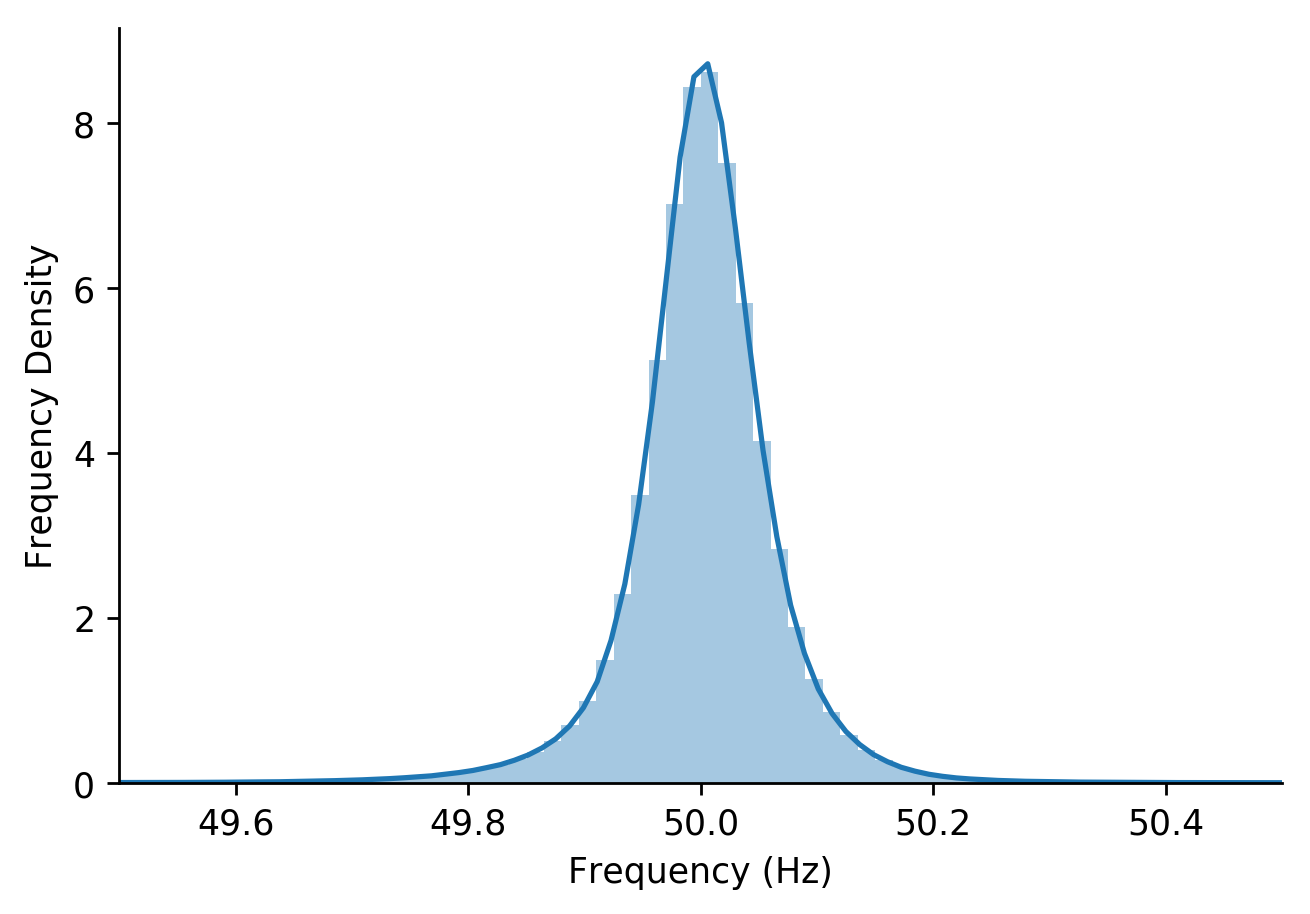

In [31]:
s_freq = df_freq.frequency_Hz
s_freq = s_freq[(s_freq>49.25) & (s_freq<50.75)]

## Plotting
fig = plt.figure(dpi=250)
ax = plt.subplot()

sns.distplot(s_freq, ax=ax, bins=100)

plt.xlim(49.5, 50.5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Density')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

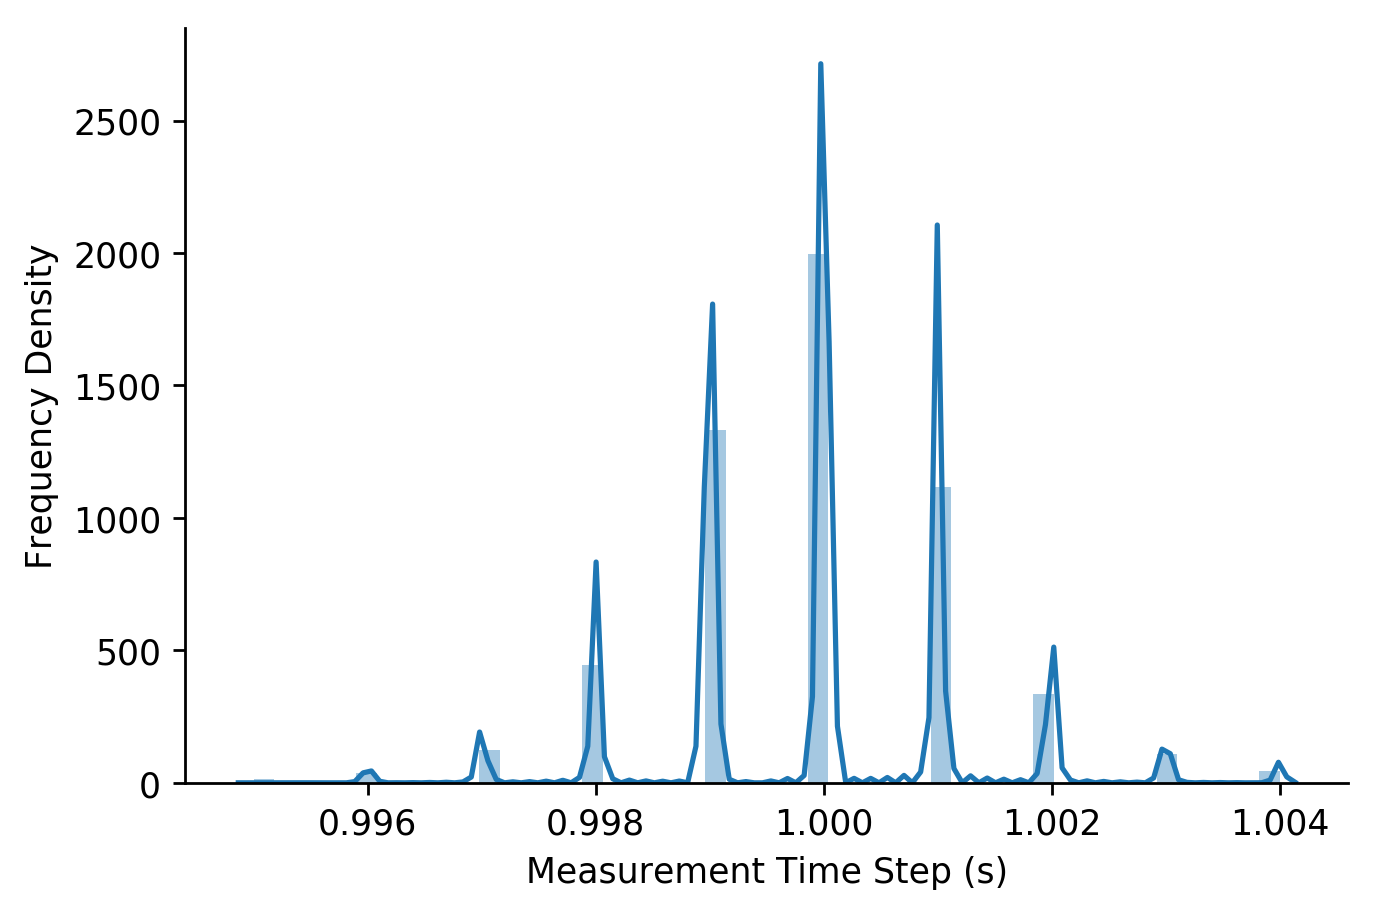

In [97]:
s_steps = df_freq.UTC_timestamp - df_freq.UTC_timestamp.shift(1)
s_steps = s_steps.dt.total_seconds().dropna()
s_steps = s_steps[(s_steps<1.005) & (s_steps>0.995)]

## Plotting
fig = plt.figure(dpi=250)
ax = plt.subplot()

sns.distplot(s_steps, ax=ax)

plt.xlabel('Measurement Time Step (s)')
plt.ylabel('Frequency Density')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<br>

We should also inspect the outlier values

In [77]:
s_steps = df_freq.UTC_timestamp - df_freq.UTC_timestamp.shift(1)
s_steps = s_steps.dt.total_seconds().dropna()

total_pct_1s = 100*s_steps[(s_steps<1.005) & (s_steps>0.995)].shape[0]/s_steps.shape[0]
print(f'Percentage of time steps around 1s: {round(total_pct_1s, 2)}%')

Percentage of time steps around 1s: 98.54%


In [79]:
s_steps = df_freq.UTC_timestamp - df_freq.UTC_timestamp.shift(1)
s_steps = s_steps.dt.total_seconds().dropna()

s_outliers = s_steps[~((s_steps<1.005) & (s_steps>0.995))]
s_outliers.head()

1114    1.059
2916    1.060
4718    1.060
6520    1.060
8322    1.060
Name: UTC_timestamp, dtype: float64

In [83]:
s_outliers.shape[0]

374696

In [88]:
s_outliers[s_outliers>2].shape[0]

614

In [89]:
s_outliers[s_outliers<0].shape[0]

524

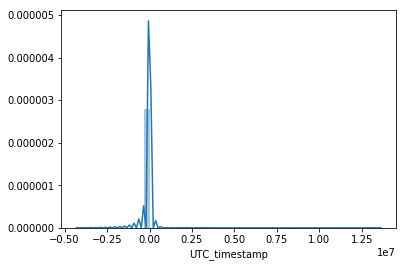

In [91]:
sns.distplot(s_outliers)

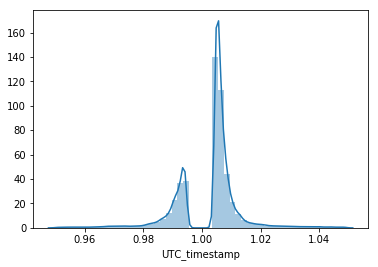

In [95]:
sns.distplot(s_outliers[(s_outliers>0.95) & (s_outliers<1.05)])